<a href="https://colab.research.google.com/github/egorssed/Galaxy_modelling_VAE/blob/main/VAE_performance_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import copy
import matplotlib.pyplot as plt
import matplotlib as mpl
import keras.backend as K
import tensorflow as tf
from google.colab import drive
drive.mount('/content/drive')
Folder='/content/drive/My Drive/TP4b/'

import sys
import os
sys.path.append(Folder+'/Modules')

#Utility modules
import Variational_autoencoder as VAE
import VAE_analysis as Analysis
import Image_Fits_Stats
import Visual_analysis

VAE.image_size=64
VAE.batch_size = 32
VAE.latent_dim = 64
VAE.start_lr = 1e-6

Mounted at /content/drive


### Prepare the data

In [16]:
from sklearn.model_selection import train_test_split


#We normalize the data to [0,1]

#Read the images and the features from the google drive
galaxy_images=np.load(Folder+'Data/Radial_cut=0.05/Images_MAD_Filtered.npy')
df=pd.read_csv(Folder+'Data/Radial_cut=0.05/Labels_MAD_Filtered.csv',index_col=0)

#Leave the number of images multiple of the batch_size
Size_of_dataset=len(galaxy_images[:-(len(galaxy_images)%VAE.batch_size)])
Number_of_batches=Size_of_dataset//VAE.batch_size
df=df.iloc[:Size_of_dataset]
df['Noise_sigma']=df['Noise_sigma']/df['max_I']
galaxy_images=galaxy_images[:Size_of_dataset]

#Bring images to a proper tensorial form
gal_dataset_images=np.reshape(VAE.normalize_image(copy.deepcopy(galaxy_images)), 
                              (len(galaxy_images), galaxy_images.shape[1], galaxy_images.shape[2], 1)).astype('float32')
#Separate the features we are eager to predict in the latent space
Features=['max_I','Noise_sigma']

#Extract test dataset
x_train,x_test,y_train,y_test= train_test_split(gal_dataset_images, df[Features].astype('float32'), test_size=round(0.05*Number_of_batches)*VAE.batch_size,random_state=42)
#Extract train and validation datasets
x_train, x_val , y_train, y_val= train_test_split(x_train, y_train, test_size=round(0.05*Number_of_batches)*VAE.batch_size,random_state=42)
#All the sets have number of galaxies which is a multiple of the batch size (32)
#The random_state is fixed so the split is reproducible yet random

Label the images such that we can pass additional information to the reconstruction loss functions

In [3]:
Features_number=len(Features)
Features_means=df[Features].mean(axis=0)
Features_stds=df[Features].std(axis=0)

def make_labeled_images(x,labels):
  res=np.zeros((len(x),x.shape[1]+1,x.shape[2],1))
  res[:,:-1,:,:]=x
  res[:,-1,:Features_number,0]=labels
  return res.astype('float32')

x_train_labeled=make_labeled_images(x_train,y_train)
x_test_labeled=make_labeled_images(x_test,y_test)
x_val_labeled=make_labeled_images(x_val,y_val)
galaxies_labeled=make_labeled_images(gal_dataset_images,df[Features])

In [17]:
#Data to estimate model's quality

COSMOS_indices_to_compare=np.zeros(8,dtype=int)
COSMOS_indices_to_compare=[33671, 25576, 45805, 31577, 41707, 19844, 13628,  8624]
images_to_compare_indices=df[np.isin(df.COSMOS_index,COSMOS_indices_to_compare)].index
imgs=np.zeros((32,64,64,1))
imgs[:8] = gal_dataset_images[images_to_compare_indices]
labels_to_compare=np.ones((32,2))
labels_to_compare[:8]=df.iloc[images_to_compare_indices][['max_I','Noise_sigma']]
n_compare = 8

In [7]:
df.shape

(25472, 43)

# Different models comparison 

In [ ]:
beta_vae=1e-2
activation='softplus'
loss_type='mse'

models,model_loss_function,reconstruction_loss_function,regularization_loss_function=\
  VAE.get_VAE(activation,loss_type,beta_vae=beta_vae)

Checkpoint_to_load=80
Checkpoint_name='Models/Pretrain_MAE_beta=1e-2_epoch_130/3*MSE_beta=1e-2/'
Checkpoints_Folder=Folder+Checkpoint_name

models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

In [ ]:
Benchmark_images=np.zeros()

In [23]:
df.iloc[images_to_compare_indices][['PSNR','Noise_sigma']]

PSNR  Noise_sigma
4359   37.063375     0.014023
6882   47.944278     0.004007
9978   46.587462     0.004684
12796  48.036044     0.003965
15769  45.637536     0.005225
16829  51.052988     0.002801
20855  54.982427     0.001782
22933  44.902222     0.005687

In [19]:
1/df.iloc[images_to_compare_indices][['Noise_sigma']]

Noise_sigma
4359     71.313009
6882    249.582362
9978    213.487806
12796   252.233163
15769   191.371305
16829   356.984523
20855   561.204775
22933   175.837341

In [70]:
def additional_noise_std(original_std,target_SNR):
    additional_variance=np.power(10,-target_SNR/10)-original_std**2
    if additional_variance<0:
      return 0
    else:
      return np.sqrt(additional_variance)

def add_noise(image,std):
    image+=np.random.normal(0,std,(64,64,1))
    image/=image.max()
    image[image<0]=0
    return image

def change_images(imgs,target_SNR):
  imgs_SNR=imgs[:8].copy()
  for i in range(8):
    std=additional_noise_std(df.iloc[images_to_compare_indices][['Noise_sigma']].iloc[i][0],target_SNR)
    imgs_SNR[i]=add_noise(imgs_SNR[i],std)

  return imgs_SNR

Maximal brightness 1.0


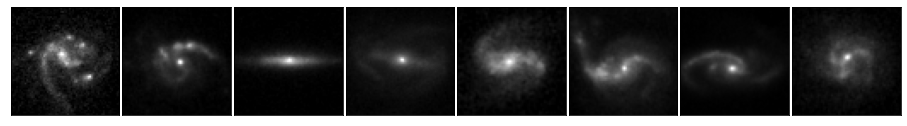

In [47]:
Analysis.plot_galaxies(imgs[:8])

In [45]:
imgs_40=imgs[:8].copy()
for i in range(8):
  std=additional_noise_std(df.iloc[images_to_compare_indices][['Noise_sigma']].iloc[i][0],40)
  imgs_40[i]=add_noise(imgs_40[i],std)

Maximal brightness 1.0


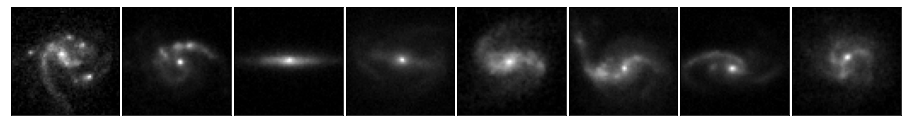

In [72]:
imgs_40=change_images(imgs,40)
Analysis.plot_galaxies(imgs_40[:8])

Maximal brightness 1.0


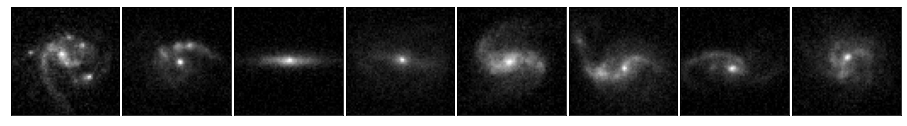

In [73]:
imgs_30=change_images(imgs,30)
Analysis.plot_galaxies(imgs_30[:8])

Maximal brightness 1.0


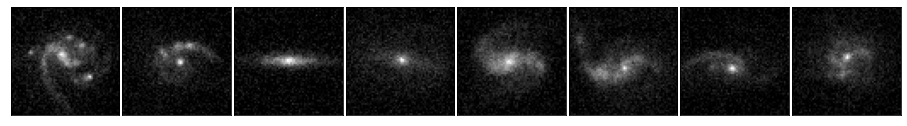

In [74]:
imgs_25=change_images(imgs,25)
Analysis.plot_galaxies(imgs_25[:8])

Maximal brightness 1.0


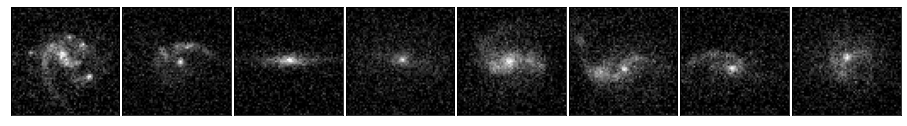

In [75]:
imgs_20=change_images(imgs,20)
Analysis.plot_galaxies(imgs_20[:8])

In [76]:
benchmark_images=np.zeros((32,64,64,1))
benchmark_images[:8]=imgs_40[:8]
benchmark_images[8:16]=imgs_30[:8]
benchmark_images[16:24]=imgs_25[:8]
benchmark_images[24:32]=imgs_20[:8]

Maximal brightness 1.0


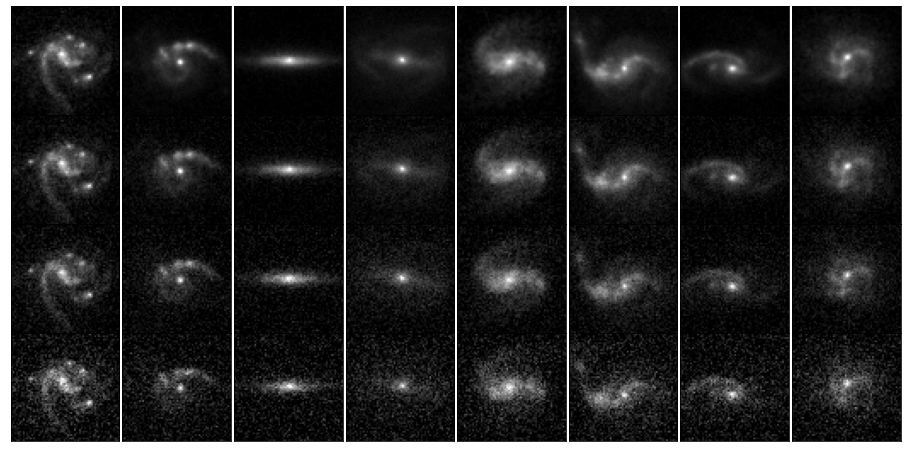

In [79]:
Analysis.plot_galaxies(benchmark_images[:8],benchmark_images[8:16],benchmark_images[16:24],benchmark_images[24:32])

In [80]:
np.save(Folder+'Data/Radial_cut=0.05/Benchmark data/Images.npy',benchmark_images[:8])
np.save(Folder+'Data/Radial_cut=0.05/Benchmark data/PSNR.npy',[40,30,25,20])

In [ ]:
imgs_BCE_Sigm=K.eval(models['decoder'](models['z_meaner'](imgs)))

In [ ]:
imgs_chisq_soft=K.eval(models['decoder'](models['z_meaner'](imgs)))

In [ ]:
imgs_mae_soft=K.eval(models['decoder'](models['z_meaner'](imgs)))

In [ ]:
imgs_final_soft=K.eval(models['decoder'](models['z_meaner'](imgs)))

Maximal brightness 1.0


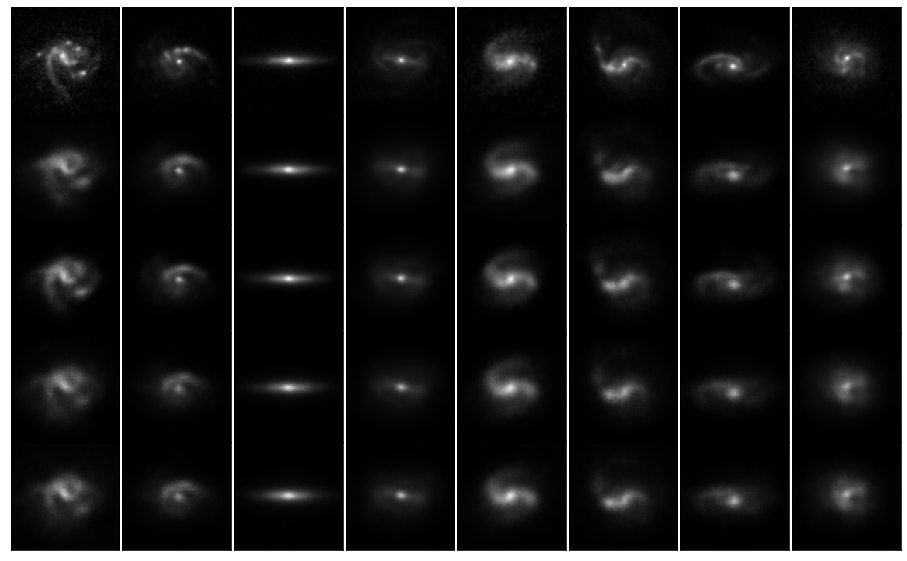

In [ ]:
Analysis.plot_galaxies(imgs[:8],imgs_BCE_Sigm[:8],imgs_chisq_soft[:8],imgs_mae_soft[:8],imgs_final_soft[:8])

In [ ]:
comparison_array=np.zeros((5,64,64,1))
comparison_array[0]=imgs[4]
comparison_array[1]=imgs_BCE_Sigm[4]
comparison_array[2]=imgs_chisq_soft[4]
comparison_array[3]=imgs_mae_soft[4]
comparison_array[4]=imgs_final_soft[4]

Maximal brightness 1.0


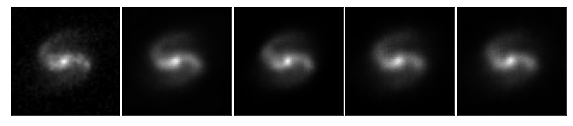

In [ ]:
Analysis.plot_galaxies(comparison_array)

In [ ]:
chi_sq_loss=VAE.get_reconstruction_loss('chi_sq')
mse_loss=VAE.get_reconstruction_loss('mse')

In [ ]:
comparison_labels=np.ones((5,2))*labels_to_compare[4]

In [ ]:
comparison_chi_sq=K.eval(chi_sq_loss((np.ones((5,64,64,1))*imgs[4]),comparison_array,comparison_labels))
comparison_mse=K.eval(mse_loss((np.ones((5,64,64,1))*imgs[4]),comparison_array,comparison_labels))

Maximal brightness 324.53564692286596


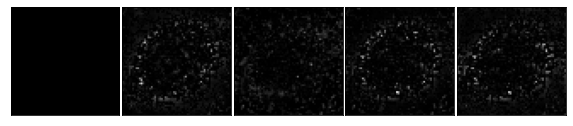

In [ ]:
Analysis.plot_galaxies(comparison_chi_sq)

Maximal brightness 0.033395226612643825


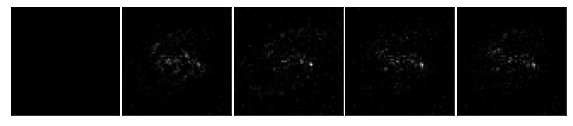

In [ ]:
Analysis.plot_galaxies(comparison_mse)

In [ ]:
comparison_mse.mean(axis=-1).mean(axis=-1)

array([0.        , 0.00036987, 0.00036212, 0.00034966, 0.00034393])

In [ ]:
imgs_mae_soft_Big=K.eval(models['decoder'](models['z_meaner'](imgs)))

In [ ]:
imgs_chisq_soft_Big=K.eval(models['decoder'](models['z_meaner'](imgs)))

In [ ]:
imgs_BCE_Sigm_Big=K.eval(models['decoder'](models['z_meaner'](imgs)))

Maximal brightness 1.0


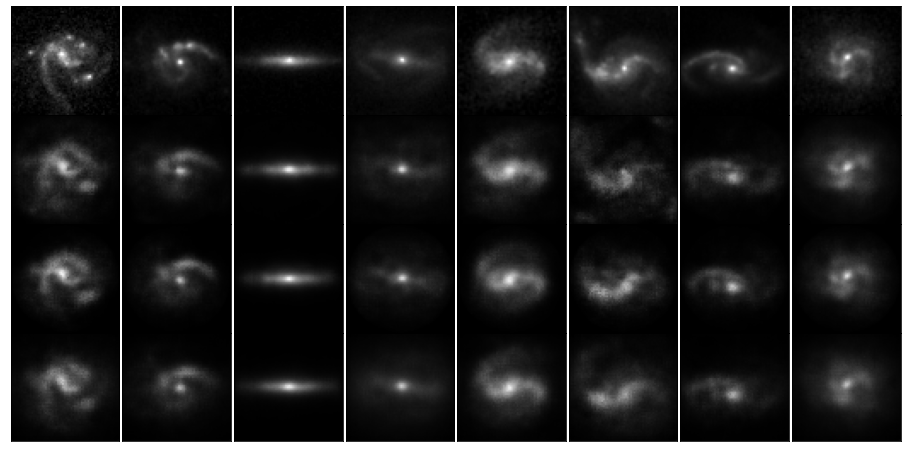

In [ ]:
Analysis.plot_galaxies(imgs[:8],imgs_BCE_Sigm_Big[:8],imgs_chisq_soft_Big[:8],imgs_mae_soft_Big[:8])

In [ ]:
def numerical_reconstruction_quality(images_labeled,decoded,reconstruction_loss_function):
        images=images_labeled[:,:-1,:,:]
        #Amplitudes and gaussian noises
        labels=images_labeled[:,-1,:,0]


        fig,ax=plt.subplots(1,3,figsize=(10,5))
        maxima=K.eval(decoded).max(axis=(1,2,3))
        #Relative absolute error for images_true normalized to 1.
        maxima_RAE=np.abs(maxima-1)
        ax[0].hist(maxima,bins=20)
        ax[0].set_title('Distribution of reconstructed maximum')

        reconstruction_loss=K.eval(reconstruction_loss_function(images,decoded,labels)/4096)
        reconstruction_loss=np.sort(reconstruction_loss)[:int(len(reconstruction_loss)*0.99)]
        ax[1].hist(reconstruction_loss,bins=40)
        ax[1].set_title('reconstruction loss')

        SSIM=tf.image.ssim(images.astype('double'), decoded.astype('double'),max_val=1,filter_size=8).numpy()
        ax[2].hist(SSIM,bins=20)
        ax[2].set_title('SSIM')
        plt.show()

        print('Max values RAE {:.3f} ± {:.3f}, median {:.3f}'.format(maxima_RAE.mean(),maxima_RAE.std(),np.median(maxima_RAE)))
        print('reconstruction loss values {:.6f} ± {:.6f}, median {:.6f}'.format(reconstruction_loss.mean(),reconstruction_loss.std(),np.median(reconstruction_loss)))
        print('SSIM values {:.3f} ± {:.3f}, median {:.3f}'.format(SSIM.mean(),SSIM.std(),np.median(SSIM)))

# MSE Fine-Tune

## MSE

In [ ]:
beta_vae=1e-2
activation='softplus'
loss_type='mse'

models,model_loss_function,reconstruction_loss_function,regularization_loss_function=\
  VAE.get_VAE(activation,loss_type,beta_vae=beta_vae)

Checkpoint_to_load=80
Checkpoint_name='Models/Pretrain_MAE_beta=1e-2_epoch_130/3*MSE_beta=1e-2/'
Checkpoints_Folder=Folder+Checkpoint_name

models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

In [ ]:
reconstruction_loss_function(imgs,imgs,labels_to_compare).shape

TensorShape([32])

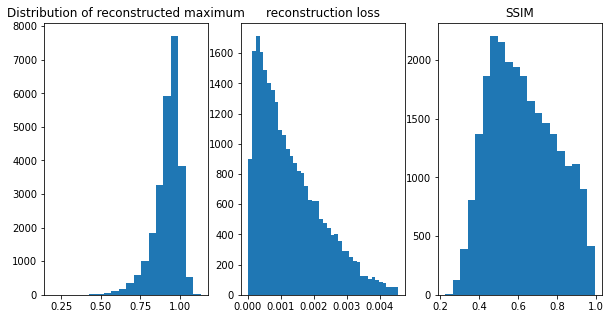

Max values RAE 0.087 ± 0.082, median 0.063
reconstruction loss values 0.001291 ± 0.000968, median 0.001050
SSIM values 0.625 ± 0.168, median 0.608


In [ ]:
numerical_reconstruction_quality(galaxies_labeled,decoded,reconstruction_loss_function)

8
Maximal brightness 1.0


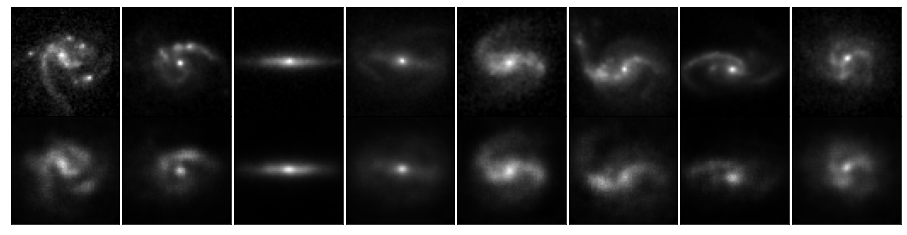

In [ ]:
Analysis.present_reconstruction(models['vae'],imgs,reconstruction_loss_function=reconstruction_loss_function,labels=labels_to_compare)

In [ ]:
z_means=models['z_meaner'].predict(gal_dataset_images)
z_log_vars=models['z_log_varer'].predict(gal_dataset_images)
decoded=models['vae'].predict(gal_dataset_images)
std_of_mu=z_means.std(axis=0)
mean_of_var=(np.exp(z_log_vars/2)).mean(axis=0)
ratio=std_of_mu/mean_of_var

Maximal brightness 0.90049624


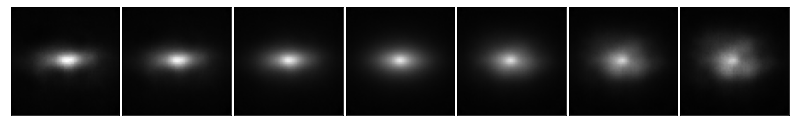

Maximal brightness 0.88291293


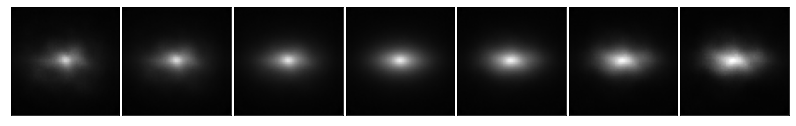

Maximal brightness 0.9023929


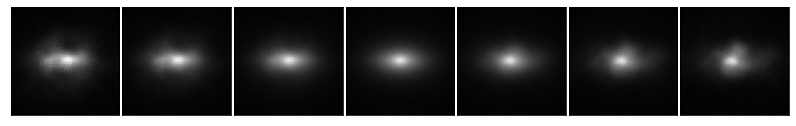

Maximal brightness 0.8860538


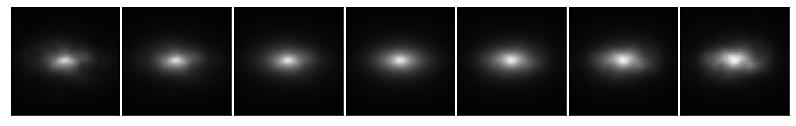

In [ ]:
Analysis.galaxy_properties_from_latent_variables(models,z_means,number_of_z_to_consider=4,dimensions='2d',sort_array=ratio)

## SSIM

In [ ]:
beta_vae=1e-2
activation='softplus'
loss_type='mse'

models,model_loss_function,reconstruction_loss_function,regularization_loss_function=\
  VAE.get_VAE(activation,loss_type,beta_vae=beta_vae)

Checkpoint_to_load=70
Checkpoint_name='Models/Pretrain_MAE_beta=1e-2_epoch_130/SSIM_beta=0.5*1e-4/'
Checkpoints_Folder=Folder+Checkpoint_name

models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

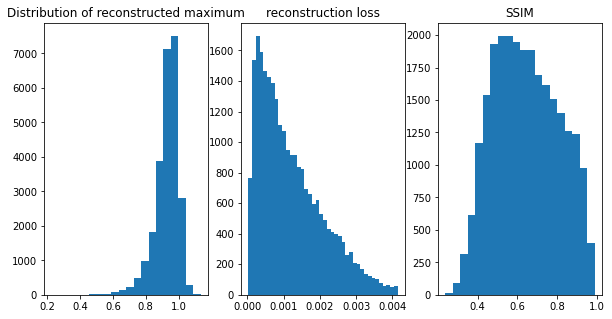

Max values RAE 0.078 ± 0.070, median 0.059
reconstruction loss values 0.001208 ± 0.000884, median 0.000990
SSIM values 0.645 ± 0.162, median 0.636


In [ ]:
numerical_reconstruction_quality(galaxies_labeled,decoded,reconstruction_loss_function)

InvalidArgumentError: ignored

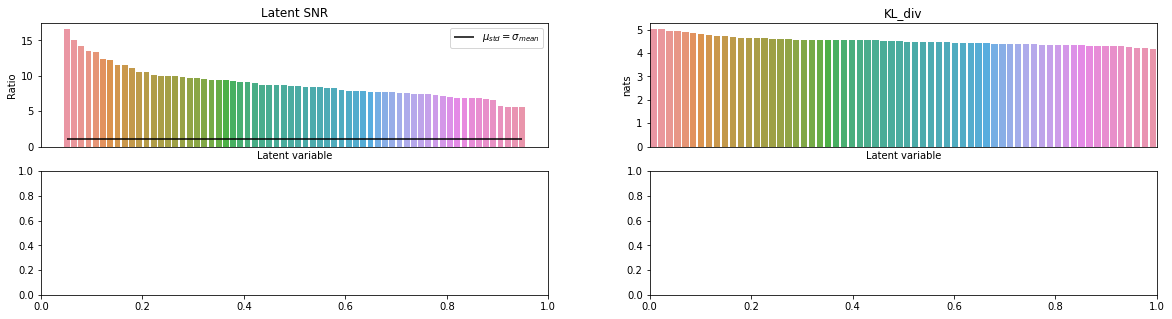

In [ ]:
Analysis.Show_latent_distr(models,x_test_labeled,reconstruction_loss_function,regularization_loss_function,loss_stats=True)

## MAE-SSIM

In [ ]:
beta_vae=1e-2
activation='softplus'
loss_type='mse'

models,model_loss_function,reconstruction_loss_function,regularization_loss_function=\
  VAE.get_VAE(activation,loss_type,beta_vae=beta_vae)

Checkpoint_to_load=80
Checkpoint_name='Models/Pretrain_MAE_beta=1e-2_epoch_130/0.5_MAE_SSIM_beta=0.5*1e-4/'
Checkpoints_Folder=Folder+Checkpoint_name

models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

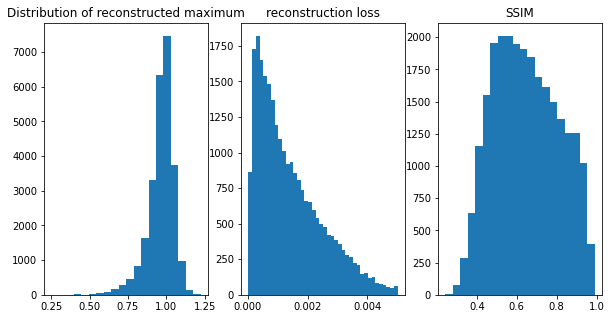

Max values RAE 0.064 ± 0.067, median 0.044
reconstruction loss values 0.001416 ± 0.001079, median 0.001130
SSIM values 0.648 ± 0.162, median 0.638


In [ ]:
numerical_reconstruction_quality(galaxies_labeled,decoded,reconstruction_loss_function)

InvalidArgumentError: ignored

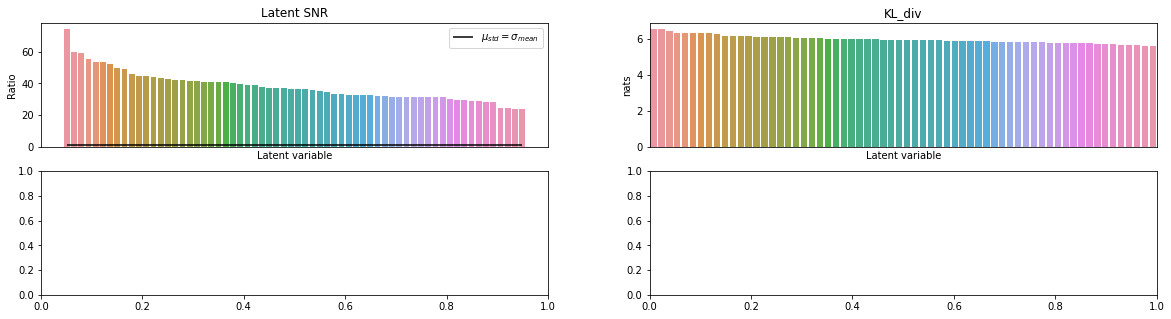

In [ ]:
Analysis.Show_latent_distr(models,x_test_labeled,reconstruction_loss_function,regularization_loss_function,loss_stats=True)

# MAE

In [ ]:
beta_vae=1e-2
activation='softplus'
loss_type='mse'

models,model_loss_function,reconstruction_loss_function,regularization_loss_function=\
  VAE.get_VAE(activation,loss_type,beta_vae=beta_vae)

Checkpoint_to_load=130
Checkpoint_name='Models/MAE+Softplus/beta_vae=1e-2/'
Checkpoints_Folder=Folder+Checkpoint_name

models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

## beta=1e-2


In [ ]:
beta_vae=1e-2
activation='softplus'
loss_type='mse'

models,model_loss_function,reconstruction_loss_function,regularization_loss_function=\
  VAE.get_VAE(activation,loss_type,beta_vae=beta_vae)

Checkpoint_to_load=130
Checkpoint_name='Models/MAE+Softplus/beta_vae=1e-2/'
Checkpoints_Folder=Folder+Checkpoint_name

models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

In [ ]:
z_means=models['z_meaner'].predict(gal_dataset_images)
z_log_vars=models['z_log_varer'].predict(gal_dataset_images)
decoded=models['vae'].predict(gal_dataset_images)
std_of_mu=z_means.std(axis=0)
mean_of_var=(np.exp(z_log_vars/2)).mean(axis=0)
ratio=std_of_mu/mean_of_var

8
Maximal brightness 1.0


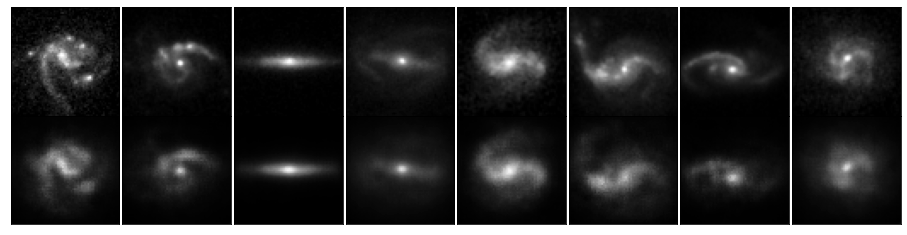

Maximal brightness 1.0


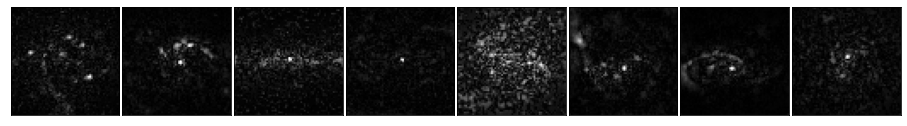

In [ ]:
Analysis.present_reconstruction(models['vae'],imgs,reconstruction_loss_function=reconstruction_loss_function,labels=labels_to_compare,grads=True)

8
Maximal brightness 1.0


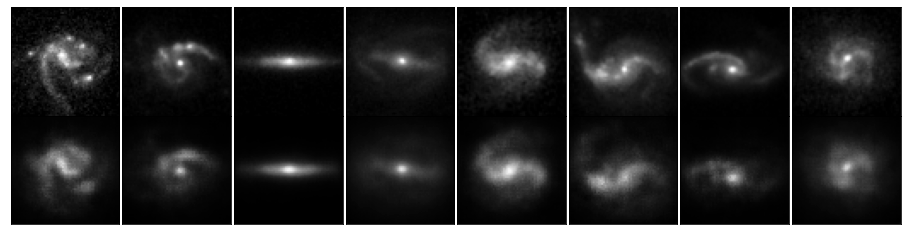

Maximal brightness 0.46618482169834863


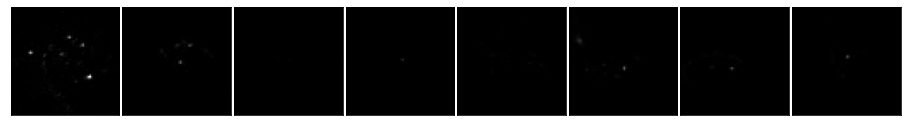

In [ ]:
Analysis.present_reconstruction(models['vae'],imgs,reconstruction_loss_function=reconstruction_loss_function,labels=labels_to_compare,resid=True)

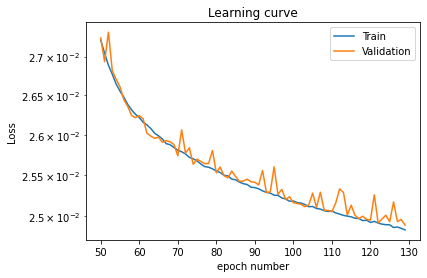

In [ ]:
Analysis.learning_curve(Checkpoints_Folder+'logs.txt',50,100000)

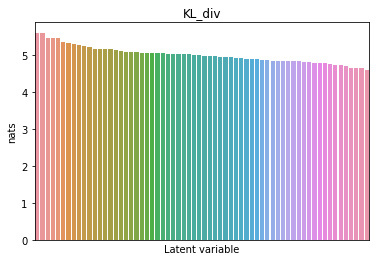

In [ ]:
DKL=Analysis.DKL_per_variable(z_means,z_log_vars)

0 130 130


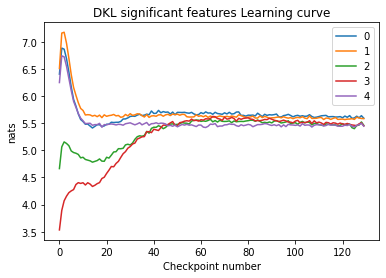

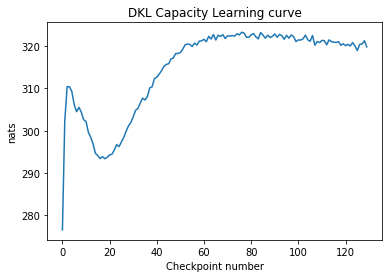

In [ ]:
Analysis.DKL_learning_curve(Checkpoints_Folder+'DKL.txt',0,100000)

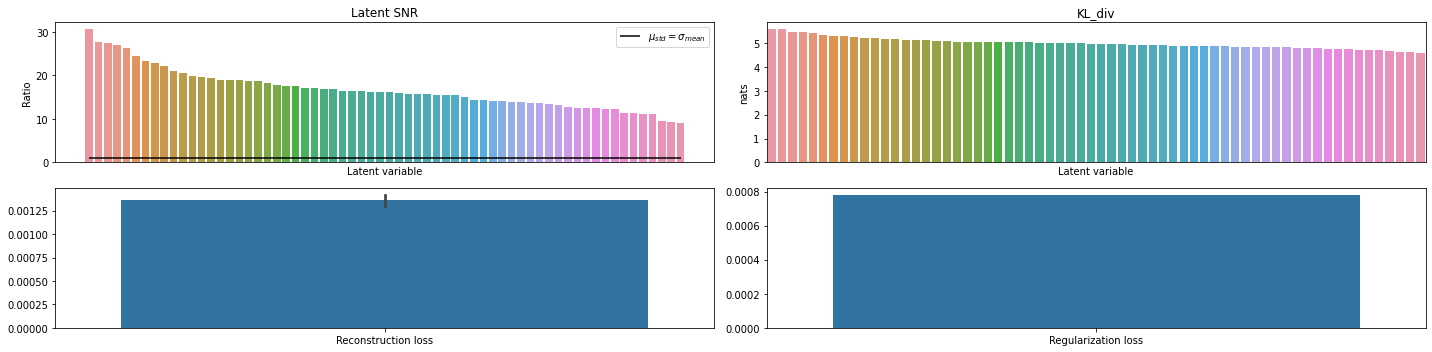

In [ ]:
Analysis.Show_latent_distr(models,x_test_labeled,reconstruction_loss_function,regularization_loss_function)

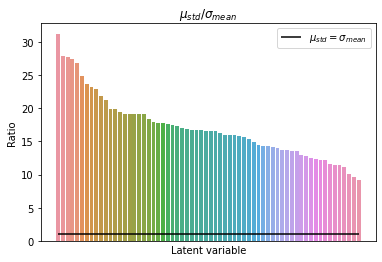

In [ ]:
Analysis.latent_relation_of_variances(ratio,sorted=True)

In [ ]:
#Analysis.latent_distribution(z_means)

Maximal brightness 0.91163844


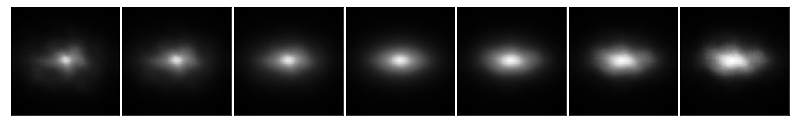

Maximal brightness 0.9292928


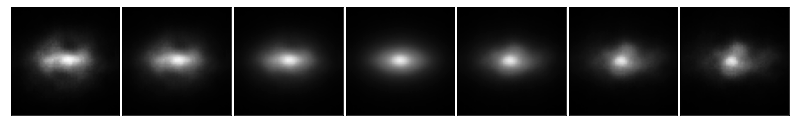

Maximal brightness 0.9219486


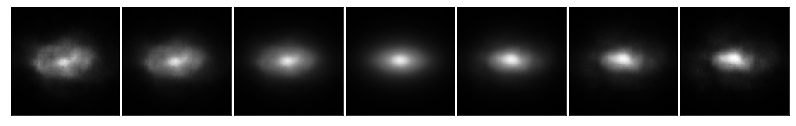

Maximal brightness 0.9083423


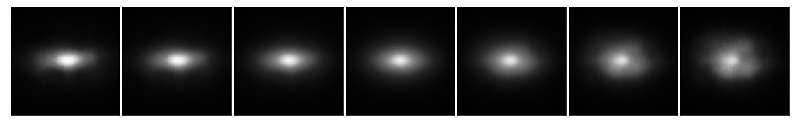

In [ ]:
Analysis.galaxy_properties_from_latent_variables(models,z_means,number_of_z_to_consider=4,dimensions='2d',sort_array=ratio)

In [ ]:
#Analysis.galaxy_properties_from_PCA(models,z_means,n_components=4,dimensions='3d')

Maximal brightness 1.2949389


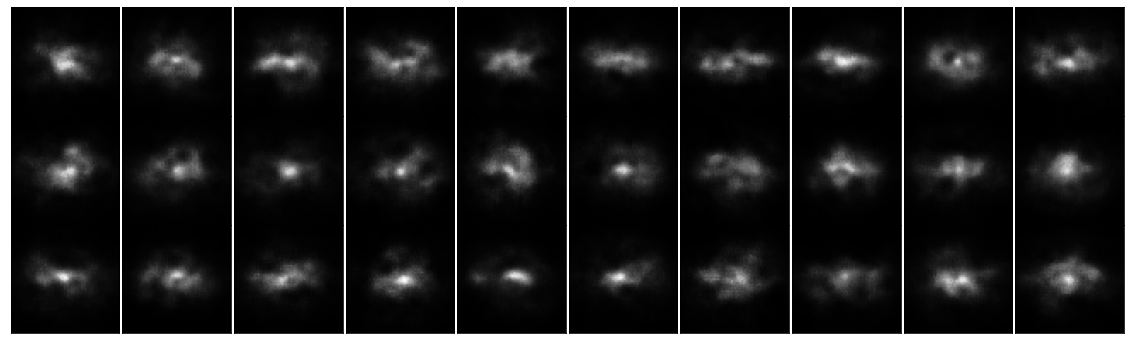

In [ ]:
Analysis.sample_random_images(models,z_means)

Maximal brightness 1.2223893


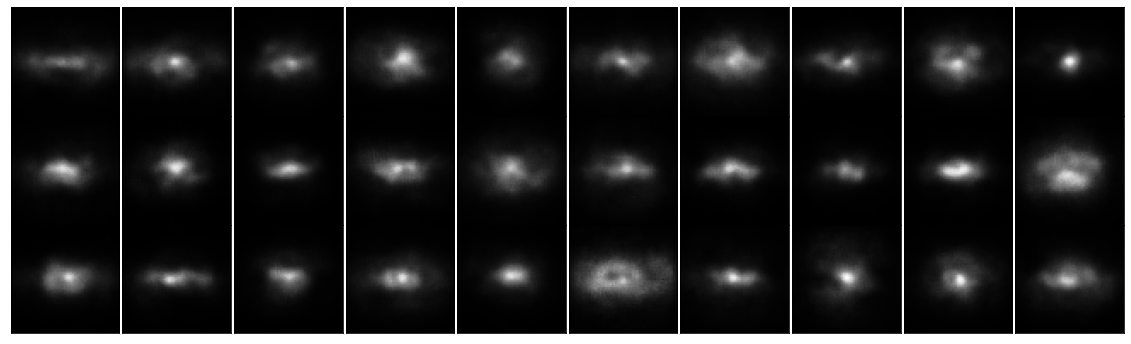

In [ ]:
Analysis.sample_random_images_PCA(models,z_means)

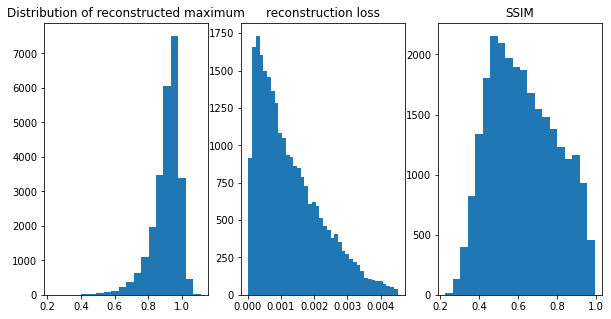

Max values RAE 0.094 ± 0.081, median 0.072
reconstruction loss values 0.001274 ± 0.000960, median 0.001031
SSIM values 0.628 ± 0.170, median 0.612


In [ ]:
Analysis.numerical_reconstruction_quality(galaxies_labeled,decoded,reconstruction_loss_function)

## beta=0.5*1e-2

In [ ]:
beta_vae=0.5*1e-2
activation='softplus'
loss_type='mse'

models,model_loss_function,reconstruction_loss_function,regularization_loss_function=\
  VAE.get_VAE(activation,loss_type,beta_vae=beta_vae)

Checkpoint_to_load=130
Checkpoint_name='Models/MAE+Softplus/beta_vae=0.5*1e-2/'
Checkpoints_Folder=Folder+Checkpoint_name

models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

InvalidArgumentError: ignored

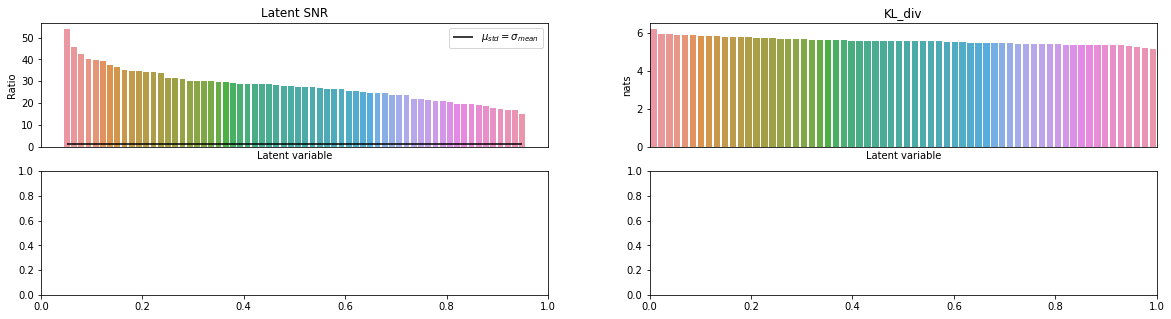

In [ ]:
Analysis.Show_latent_distr(models,x_test_labeled,reconstruction_loss_function,regularization_loss_function)

In [ ]:
z_means=models['z_meaner'].predict(gal_dataset_images)
z_log_vars=models['z_log_varer'].predict(gal_dataset_images)
decoded=models['vae'].predict(gal_dataset_images)
std_of_mu=z_means.std(axis=0)
mean_of_var=(np.exp(z_log_vars/2)).mean(axis=0)
ratio=std_of_mu/mean_of_var

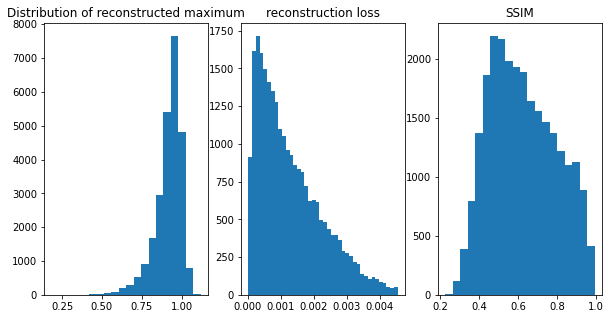

Max values RAE 0.087 ± 0.082, median 0.064
reconstruction loss values 0.001291 ± 0.000968, median 0.001051
SSIM values 0.625 ± 0.168, median 0.608


In [ ]:
Analysis.numerical_reconstruction_quality(galaxies_labeled,decoded,reconstruction_loss_function)

8
Maximal brightness 1.0042273998260498


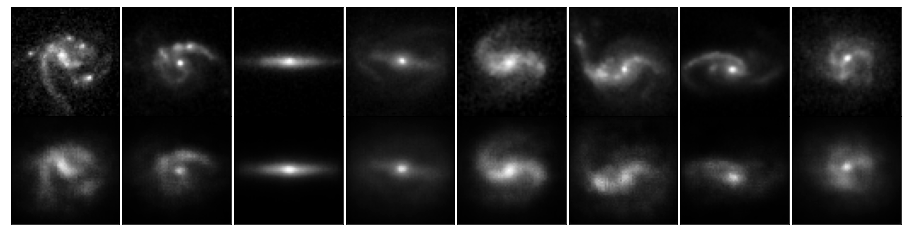

Maximal brightness 1.0


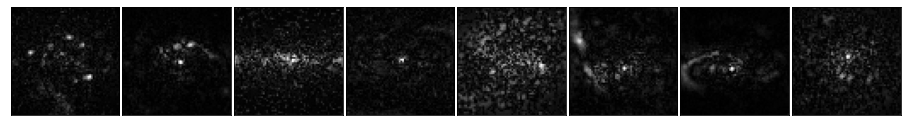

In [ ]:
Analysis.present_reconstruction(models['vae'],imgs,reconstruction_loss_function=reconstruction_loss_function,labels=labels_to_compare,grads=True)

Maximal brightness 0.7906199


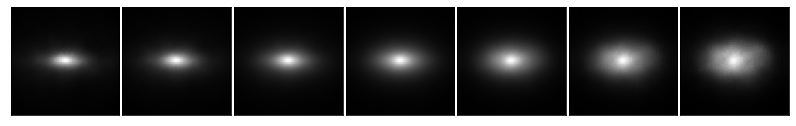

Maximal brightness 0.89528483


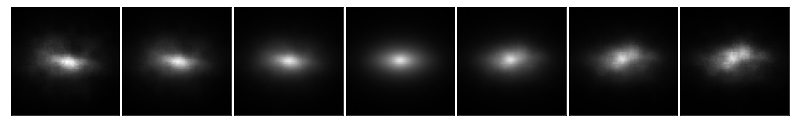

Maximal brightness 0.8671137


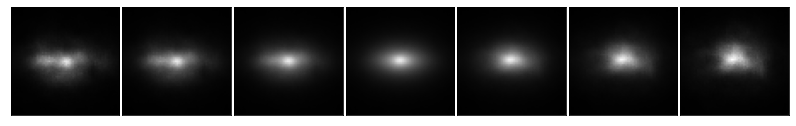

Maximal brightness 1.0473142


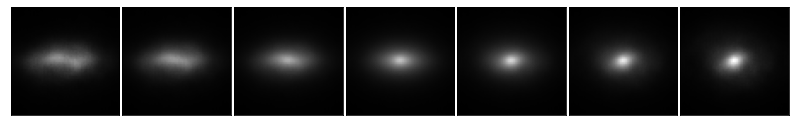

In [ ]:
Analysis.galaxy_properties_from_latent_variables(models,z_means,number_of_z_to_consider=4,dimensions='2d',sort_array=ratio)

## From Sigmoid

### Not dumped


In [ ]:
beta_vae=0.5*1e-2
activation='sigmoid'
loss_type='mse'

models,model_loss_function,reconstruction_loss_function,regularization_loss_function=\
  VAE.get_VAE(activation,loss_type,beta_vae=beta_vae)

Checkpoint_to_load=90
Checkpoint_name='Models/MAE_from_Sigmoid/Sign_grads/beta_vae=5*1e-2/'
Checkpoints_Folder=Folder+Checkpoint_name

models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

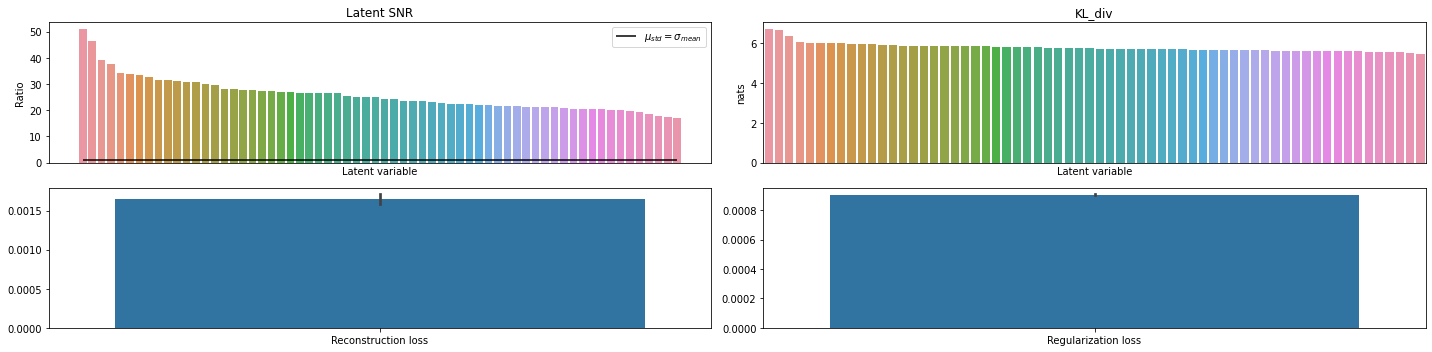

In [ ]:
Analysis.Show_latent_distr(models,x_test_labeled,reconstruction_loss_function,regularization_loss_function)

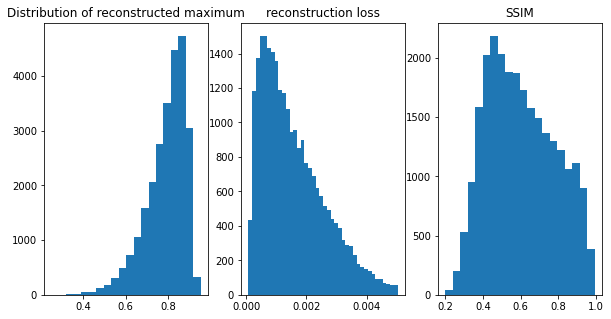

Max values RAE 0.210 ± 0.095, median 0.188
reconstruction loss values 0.001564 ± 0.001050, median 0.001318
SSIM values 0.603 ± 0.178, median 0.585


In [ ]:
decoded=models['vae'].predict(gal_dataset_images)
Analysis.numerical_reconstruction_quality(galaxies_labeled,decoded,reconstruction_loss_function)

8
Maximal brightness 1.0


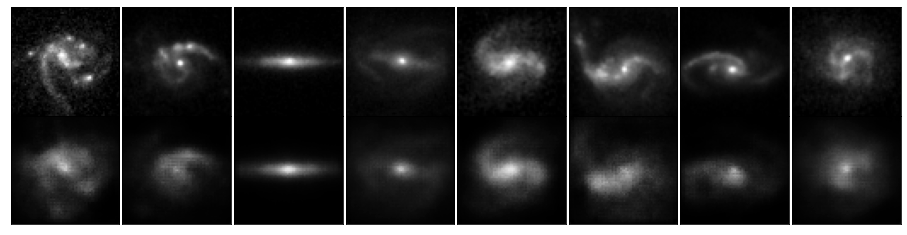

Maximal brightness 1.0


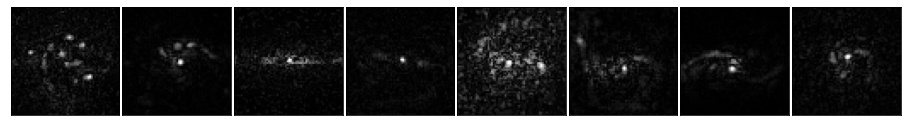

In [ ]:
Analysis.present_reconstruction(models['vae'],imgs,reconstruction_loss_function=reconstruction_loss_function,labels=labels_to_compare,grads=True)

### Dumped

#### beta=1e-2

In [ ]:
beta_vae=1e-2
activation='sigmoid'
loss_type='mse'

models,model_loss_function,reconstruction_loss_function,regularization_loss_function=\
  VAE.get_VAE(activation,loss_type,beta_vae=beta_vae)

Checkpoint_to_load=150
Checkpoint_name='Models/MAE_from_Sigmoid/Sign_grads_dumped/beta_vae=1e-2/'
Checkpoints_Folder=Folder+Checkpoint_name

models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

8
Maximal brightness 1.0


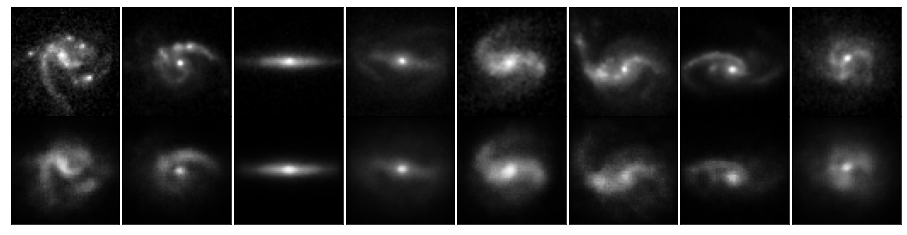

Maximal brightness 1.0


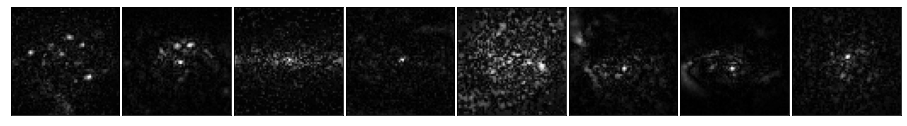

In [ ]:
Analysis.present_reconstruction(models['vae'],imgs,reconstruction_loss_function=reconstruction_loss_function,labels=labels_to_compare,grads=True)

8
Maximal brightness 1.0


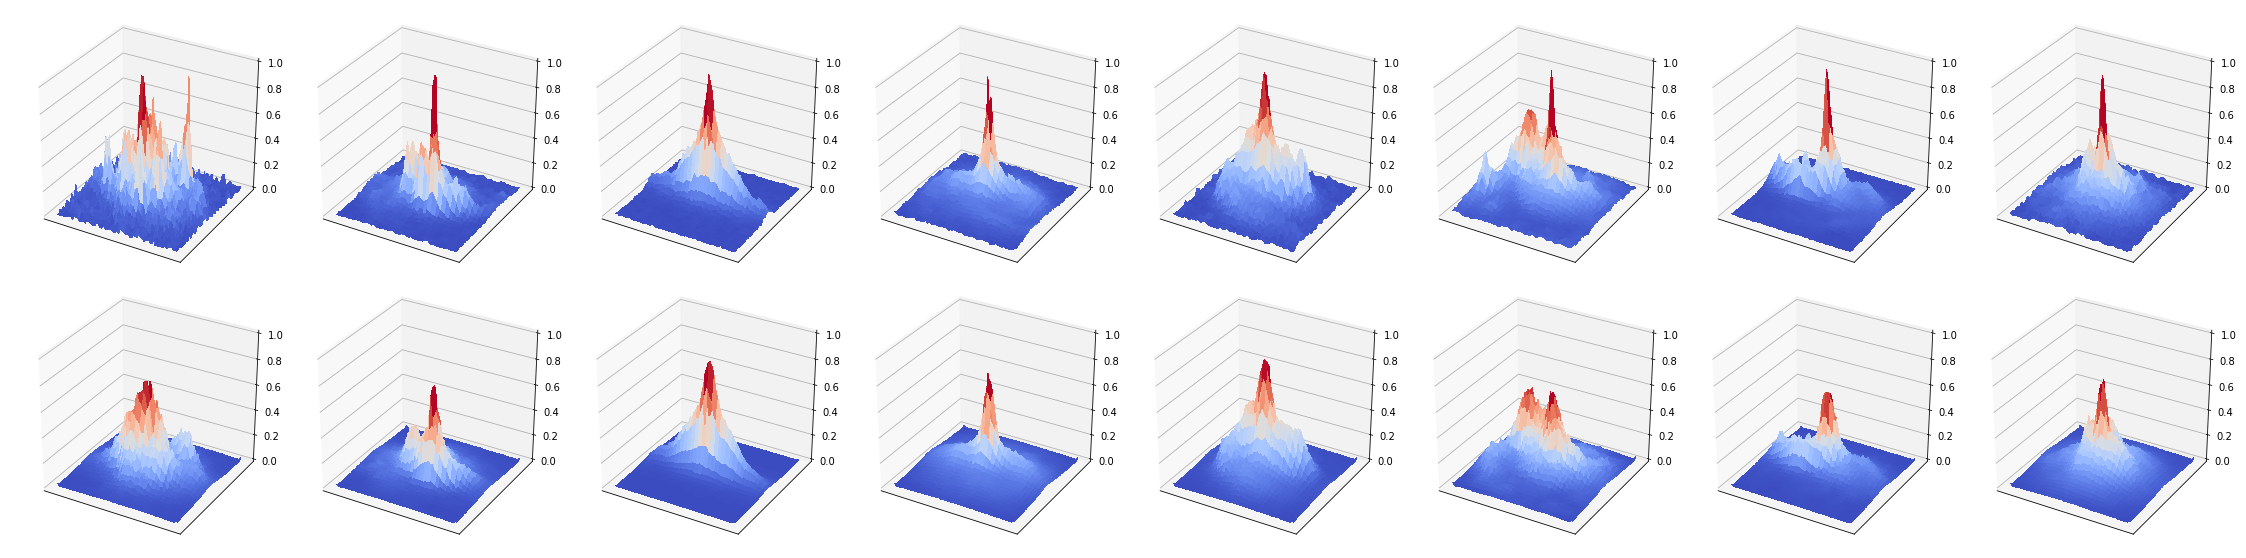

Maximal brightness 1.0


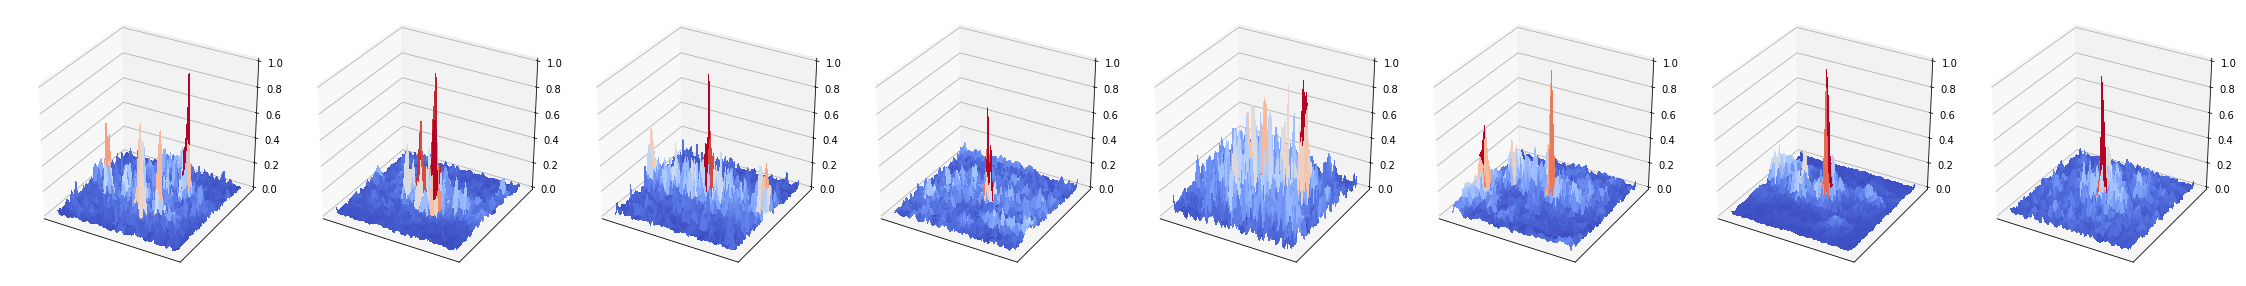

In [ ]:
Analysis.present_reconstruction(models['vae'],imgs,reconstruction_loss_function=reconstruction_loss_function,labels=labels_to_compare,grads=True,dimensions='3d')

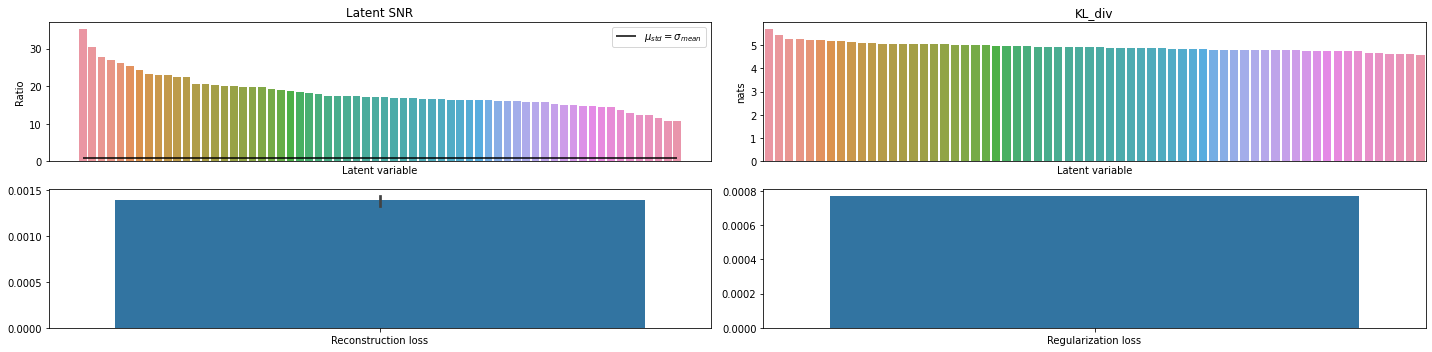

In [ ]:
Analysis.Show_latent_distr(models,x_test_labeled,reconstruction_loss_function,regularization_loss_function)

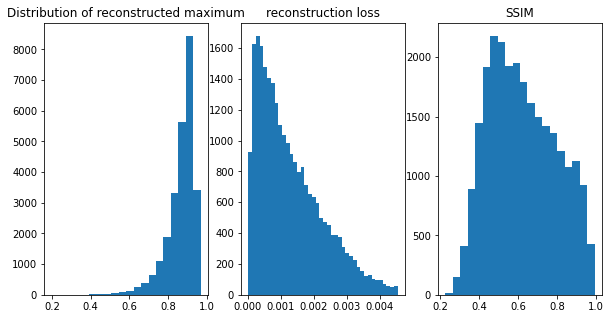

Max values RAE 0.135 ± 0.074, median 0.114
reconstruction loss values 0.001301 ± 0.000969, median 0.001061
SSIM values 0.623 ± 0.170, median 0.605


In [ ]:
decoded=models['vae'].predict(gal_dataset_images)
Analysis.numerical_reconstruction_quality(galaxies_labeled,decoded,reconstruction_loss_function)

#### beta=0.5*1e-2

In [ ]:
beta_vae=0.5*1e-2
activation='sigmoid'
loss_type='mse'

models,model_loss_function,reconstruction_loss_function,regularization_loss_function=\
  VAE.get_VAE(activation,loss_type,beta_vae=beta_vae)

Checkpoint_to_load=150
Checkpoint_name='Models/MAE_from_Sigmoid/Sign_grads_dumped/beta_vae=0.5*1e-2/'
Checkpoints_Folder=Folder+Checkpoint_name

models['vae'].load_weights(Checkpoints_Folder+'epoch_{}/Model'.format(Checkpoint_to_load))

8
Maximal brightness 1.0


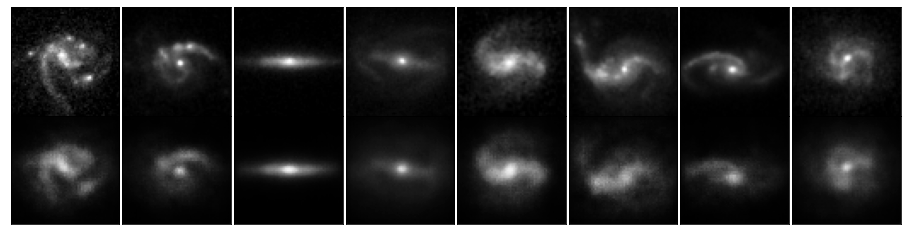

Maximal brightness 1.0


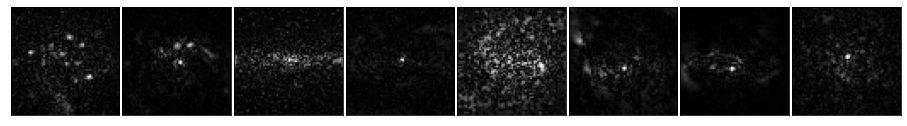

In [ ]:
Analysis.present_reconstruction(models['vae'],imgs,reconstruction_loss_function=reconstruction_loss_function,labels=labels_to_compare,grads=True)

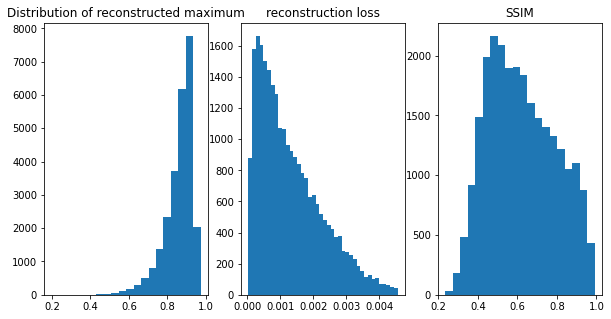

Max values RAE 0.141 ± 0.077, median 0.120
reconstruction loss values 0.001312 ± 0.000970, median 0.001071
SSIM values 0.623 ± 0.169, median 0.606


In [ ]:
decoded=models['vae'].predict(gal_dataset_images)
Analysis.numerical_reconstruction_quality(galaxies_labeled,decoded,reconstruction_loss_function)